# Example of online analysis using Volpy

This pipeline serves for analyzing data after motion correction.

It first allows to select ROIs manually if they are not present and then runs the adapted Volpy package.

### Open libraries

In [2]:
import logging
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

import numpy as np
import tifffile
import os
import h5py

import caiman as cm
import mesmerize_core as mescore
from caiman.source_extraction import cnmf, volpy
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.source_extraction.volpy import pre_processing, utils
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_25628\1342850826.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_25628\1342850826.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


## Import data

Set a list of filenames in the fnames variable to run in a row

In [3]:
fnames = ["Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif",
          "Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_15mW_1.tif",
          "Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_15mW_2.tif",
          "Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_30mW_1.tif",
          "Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_30mW_2.tif",
         "Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_1000Hz_15mW.tif"]

if isinstance(fnames,str):
    fnames = [fnames]

for name in fnames:
    if os.path.exists(name) == False:
        logging.warning(name + ' does not exits! Please correct the filename.')

## Create ROIs manually

<b> Change the path to the file path where the volpy_gui.py code is. </b>

Skip this step if the ROIs already exist

In [ ]:
%run C:/Users/Gebruiker/mambaforge/envs/caimanRui/Lib/site-packages/caiman/source_extraction/volpy/volpy_gui

## Set list of ROIs

Create a list of ROIs to be used for each of the fnames above or use one ROI for all fnames by setting a single path.

Below there are 2 forms of setting the Neurons_path variable. The first one is if the ROIs file are in the same folder as the filenames, the second one is by setting the full path. Comment the one that does not matter.

In [14]:
# If ROIs files are in the same folder of the original image, select through this for loop

#Neurons_path = []
#for i in range(0,len(fnames)):
#    gui_ROIs = os.path.join(os.path.dirname(fnames[i]), 'ROIs.hdf5')
#    if os.path.exists(gui_ROIs):
#        Neurons_path.append(gui_ROIs)
#    else:
#        logging.warning(gui_ROIs + ' does not exist! It will not be added to the variable.')
    
# If a ROIs file is used for all files, set a single Neurons_path
Neurons_path = ["Z:/Data for optimizing Volpy/Negative dye/ROIs_7mW.hdf5",
               "Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_1.hdf5",
               "Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_2.hdf5",
               "Z:/Data for optimizing Volpy/Negative dye/ROIs_30mW_1.hdf5",
               "Z:/Data for optimizing Volpy/Negative dye/ROIs_30mW_2.hdf5",
               "Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_1000Hz.hdf5"]

if isinstance(Neurons_path,str):
    Neurons_path = [Neurons_path]

if len(Neurons_path)!=1 and len(Neurons_path)!= len(fnames):
    logging.error('The size of fnames and Neurons_path is different! Select the same number of Neurons_path as fnames or solely one to be used for all files.')

## Set parameters for Volpy

In [59]:
n = 0 #Index of file to start parameters

with h5py.File(Neurons_path[n], 'r') as fl:
    ROIs = fl['mov'][()]

ROIs = ROIs                                   # region of interests
index = list(range(len(ROIs)))                # index of neurons
weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 
fr = 500                                      # Frame rate
template_size = 0.02                          # half size of the window length for spike templates, default is 20 ms 
context_size = 70                             # number of pixels surrounding the ROI to censor from the background PCA
visualize_ROI = False                         # whether to visualize the region of interest inside the context region
flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
clip = 100                                    # maximum number of spikes to form spike template
threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
min_spikes= 10                                # minimal spikes to be found
pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
do_plot = False                               # plot detail of spikes, template for the last iteration
ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
sub_freq = 10                                 # frequency for subthreshold extraction
weight_update = 'ridge'                       # ridge or NMF for weight update
n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters
nPC_bg = 8                                    # number of principal components from the background to remove from trace

opts_dict={'fnames': fnames[n],
           'fr': fr,
           'ROIs': ROIs,
           'index': index,
           'weights': weights,
           'template_size': template_size, 
           'context_size': context_size,
           'visualize_ROI': visualize_ROI, 
           'flip_signal': flip_signal,
           'hp_freq_pb': hp_freq_pb,
           'clip': clip,
           'threshold_method': threshold_method,
           'min_spikes':min_spikes,
           'pnorm': pnorm, 
           'threshold': threshold,
           'do_plot':do_plot,
           'ridge_bg':ridge_bg,
           'sub_freq': sub_freq,
           'weight_update': weight_update,
           'n_iter': n_iter,
           'nPC_bg': nPC_bg}

opts = volparams(params_dict=opts_dict)                 

    20587600 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    20587601 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    20587607 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
    20587609 [volparams.py:                 set():95] [25628] Changing key index in group data from None to [0]
    20587613 [volparams.py:                 set():95] [25628] Changing key context_size in group volspike from 35 to 70
    20587615 [volparams.py:                 set():95] [25628] Changing key sub_freq in group volspike from 20 to 10


# Iterate over all files, run VOLPY and save results

In [75]:
save = True               # Save VOLPY results
show_final = False         # Show final trace
for i in range(0,len(fnames)): 
    
    if len(Neurons_path)>1:
        with h5py.File(Neurons_path[i], 'r') as fl:
            ROIs = fl['mov'][()]
        ROIs = ROIs                                   # region of interests
        index = list(range(len(ROIs)))                # index of neurons
        
        opts.set('volspike',{'ROIs': ROIs})
        opts.set('volspike',{'index': index})
    
    opts.set('data',{'fnames': fnames[i]})

    opts = volparams(params_dict=opts_dict)                                     
    vpy = VOLPY(n_processes=1, dview=None, params=opts)
    vpy.fit(n_processes=1, dview=None)
    
    # Show final output
    if show_final == True:
        img = np.mean(cm.load(fnames[i], subindices = slice(0,500,1)),0)
        Xinds = np.where(np.any(ROIs[0] > 0, axis=1) > 0)[0]
        Yinds = np.where(np.any(ROIs[0] > 0, axis=0) > 0)[0]
        img = img[Xinds[0]:Xinds[-1] + 1, Yinds[0]:Yinds[-1] + 1]

        utils.view_components(vpy.estimates, img,[int(0)])
    
    if save == True:
        np.save(os.path.join(os.path.dirname(fnames[i]), os.path.basename(fnames[i]).split('.')[0] + '_Neurons_traces.npy'), vpy.estimates)

    21507955 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21507957 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21507960 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
    21507962 [volparams.py:                 set():95] [25628] Changing key index in group data from None to [0]
    21507962 [volparams.py:                 set():95] [25628] Changing key context_size in group volspike from 35 to 70
    21507963 [volparams.py:                 set():95] [25628] Changing key sub_freq in group volspike from 20 to 10


Now processing cell number 0


    21526991 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21536165 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21537187 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21538766 [volparams.py:                 set():95] [25628] Changing key fnames in group data from Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_15mW_1.tif
    21538768 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21538769 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21538779 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [

Now processing cell number 0


    21557251 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21564282 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21564980 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21566219 [volparams.py:                 set():95] [25628] Changing key fnames in group data from Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_15mW_2.tif
    21566221 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21566224 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21566237 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [

Now processing cell number 0


    21585892 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21594682 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21595662 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21597201 [volparams.py:                 set():95] [25628] Changing key fnames in group data from Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_30mW_1.tif
    21597204 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21597206 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21597218 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [

Now processing cell number 0


    21614648 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21620956 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21621827 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21623102 [volparams.py:                 set():95] [25628] Changing key fnames in group data from Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_30mW_2.tif
    21623104 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21623105 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21623109 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [

Now processing cell number 0


    21639025 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21646107 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21646847 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21648208 [volparams.py:                 set():95] [25628] Changing key fnames in group data from Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_1000Hz_15mW.tif
    21648209 [volparams.py:                 set():95] [25628] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Negative dye/Ace_mNeon2_500Hz_7mW.tif
    21648210 [volparams.py:                 set():95] [25628] Changing key fr in group data from None to 500
    21648221 [volparams.py:                 set():95] [25628] Changing key ROIs in group data from None to [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0

Now processing cell number 0


    21664907 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21671040 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template
    21671812 [spikepursuit.py:     adaptive_thresh():628] [25628] Selecting top 100 spikes for template


# Open saved files and use data

Data is stored in .npy files. They should be opened as dictionaries and then the data stored should be the same as in Volpy package.
Check Volpy paper to know remaining variables

#### <b>Main keys:</b>
<ul>
    <li><b> raw_ROI: </b> Raw traces (t), weights (weights_init) and mean image (mean_im). </li> 
    <li><b> t: </b> Trace with final weights </li> 
    <li><b> ts: </b> Denoised trace with final weights </li> 
    <li><b> t_rec: </b> Final spikes </li> 
    <li><b> t_sub: </b> Trace of subthreshold signal with the given frequency </li> 
</ul>

Z:/Data for optimizing Volpy/Negative dye\Neurons_traces.npy


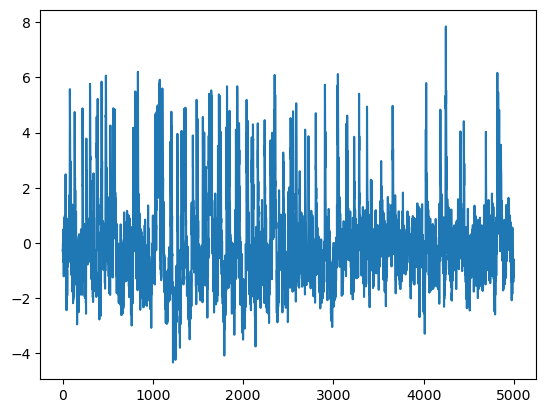

In [73]:
n = 0 #Index of file
Neurons_data = np.load(os.path.join(os.path.dirname(fnames[0]), 'Neurons_traces.npy'), allow_pickle = True)

cell = 0  #index of cells. First cell has index 0

raw_t = Neurons_data.item(cell).get('rawROI')[0].get('t')            # Raw signal
t = Neurons_data.item(cell).get('t')                                 # Signal with final weights
ts = Neurons_data.item(cell).get('ts')                               # Denoised signal
t_rec = Neurons_data.item(cell).get('t_rec')                         # Spikes
t_sub = Neurons_data.item(cell).get('t_sub')                         # Subthrehsold signals at mentioned frequency

plt.plot(raw_t)